In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch import nn as nn
import torch.nn.functional as F

In [25]:
# Download training dataset
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)

In [26]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [27]:
test_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor(), download=True)
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: ToTensor()

In [28]:
image_tensor, label = dataset[0] # The first element which would otherwise be a PIL.Image object has been transformed to a tensor
image_tensor.shape, label

(torch.Size([1, 28, 28]), 5)

In [29]:
image_tensor[:, 10:15, 10:15]

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])

5

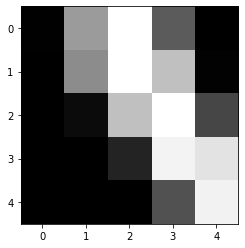

In [30]:
# Plotting the part of img_tensor as image
plt.imshow(image_tensor[0, 10:15, 10:15], cmap='gray')
label

5

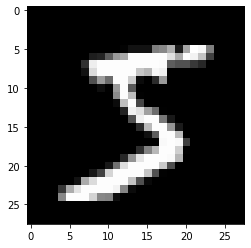

In [31]:
# Plotting the entire 28*28 pixel image
plt.imshow(image_tensor[0], cmap='gray')
label

In [32]:
# Create a validation dataset from training dataset
from torch.utils.data import random_split
train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [33]:
# Create dataloader to train and validate in batches
from torch.utils.data import DataLoader
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size)

In [34]:
class MnistModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.input_size = input_size
        self.num_classes = num_classes
        self.linear = nn.Linear(input_size, num_classes)
                      
    def forward(self, xb):
        xb = xb.reshape(-1, self.input_size)
        out = self.linear(xb)
        return out
    
    def accuracy(self, outputs, labels):
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item()/len(preds), dtype=torch.float)
    
    def training_step(self, batch):
      images, labels = batch
      out = self(images) # Generate predictions
      loss = F.cross_entropy(out, labels) # Calculate the loss
      return loss
    
    def validation_step(self, batch):
      images, labels = batch
      out = self(images)
      loss = F.cross_entropy(out, labels)
      acc = self.accuracy(out, labels)
      return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
      batch_losses = [x['val_loss'] for x in outputs]
      epoch_loss = torch.stack(batch_losses).mean() # combine losses
      batch_accs = [x['val_acc'] for x in outputs]
      epoch_acc = torch.stack(batch_accs).mean() # combine accuracies
      return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
      print('Epoch: {0}, val_loss: {1:.4f}, val_acc: {2:.4f}'.format(epoch, result['val_loss'], result['val_acc']))


model = MnistModel(input_size = 28*28, num_classes = 10)

In [35]:
# evaluate() to validates the model for each epoch
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

# fit() is to train the model
def fit(num_epochs, model, train_dl, val_dl, lr, opt_fn=torch.optim.SGD):
  history = []
  optimizer = opt_fn(model.parameters(), lr)
  for epoch in range(num_epochs):
    # Training phase
    for batch in train_dl:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    # Validation phase
    result = evaluate(model, val_dl)
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [36]:
history1 = fit(5, model, train_dl, val_dl, 0.001, torch.optim.SGD)

Epoch: 0, val_loss: 1.6928, val_acc: 0.7188
Epoch: 1, val_loss: 1.3401, val_acc: 0.7729
Epoch: 2, val_loss: 1.1310, val_acc: 0.7954
Epoch: 3, val_loss: 0.9969, val_acc: 0.8126
Epoch: 4, val_loss: 0.9042, val_acc: 0.8228


In [37]:
history2 = fit(5, model, train_dl, val_dl, 0.001, torch.optim.SGD)

Epoch: 0, val_loss: 0.8364, val_acc: 0.8291
Epoch: 1, val_loss: 0.7844, val_acc: 0.8348
Epoch: 2, val_loss: 0.7434, val_acc: 0.8385
Epoch: 3, val_loss: 0.7099, val_acc: 0.8423
Epoch: 4, val_loss: 0.6821, val_acc: 0.8452


In [38]:
history3 = fit(5, model, train_dl, val_dl, 0.001, torch.optim.SGD)

Epoch: 0, val_loss: 0.6586, val_acc: 0.8491
Epoch: 1, val_loss: 0.6383, val_acc: 0.8512
Epoch: 2, val_loss: 0.6208, val_acc: 0.8540
Epoch: 3, val_loss: 0.6052, val_acc: 0.8562
Epoch: 4, val_loss: 0.5915, val_acc: 0.8576


In [39]:
history1

[{'val_acc': 0.7188495397567749, 'val_loss': 1.6927748918533325},
 {'val_acc': 0.7728901505470276, 'val_loss': 1.340053915977478},
 {'val_acc': 0.7953821420669556, 'val_loss': 1.1310263872146606},
 {'val_acc': 0.8125995397567749, 'val_loss': 0.9969124794006348},
 {'val_acc': 0.8227508068084717, 'val_loss': 0.9041606187820435}]

Text(0.5, 1.0, 'Accuracy vs no_of epochs')

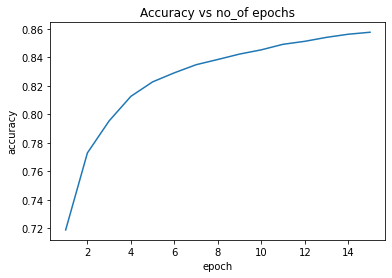

In [43]:
plt.xlabel('epoch')
plt.ylabel('accuracy')
history = history1 + history2 + history3
epochs = [i for i in range(1, len(history)+1)]
accuracies = [x['val_acc'] for x in history]
plt.plot(epochs, accuracies)
plt.title('Accuracy vs no_of epochs')